# Lending Club dataset

In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import pyarrow

In [2]:
# params
seed = 42

[Ссылка на Kaggle-dataset](https://www.kaggle.com/wordsforthewise/lending-club?select=accepted_2007_to_2018Q4.csv.gz)

Довольно популярный, особенно в последнее время. Один из топ-приоритетов при построении моделей.

Датасет в целом состоит из одобренных и отклоненных кредитных заявок. Суть следующая: сначала платформа Lending Club (LC) получает заявку на кредит и выносит решение о её одобрении. Далее заявка выставляется на сайте и ищет финансирование. Потенциально могут быть заявки, которые не нашли финансирование. Не очень понятно, куда в данных попадают такие заявки: в описании датасета и на форуме не нашел соответствующих объяснений. Кажется, сам автор датасета этого не знает:

> — Do we have access to the loans that are listed but not successfully funded?
>
> — I don't know if those are in there then, probably not. But they would be in the 'accepted' dataset if so.
>
> [(Discussion here)](https://www.kaggle.com/wordsforthewise/lending-club/discussion/253170)

***

# I. Accepted Applications

## 1. Подгрузка данных

In [3]:
# К сожалению, файл очень большой и скачать по прямой ссылке сложно.
# Сначала лучше вручную скачать данные из гугл-диска Вани П.:
# https://drive.google.com/drive/folders/1-pkYWSUwiwZXrojOeIhdhBLbvr2Rxhww?usp=sharing

df_acc = pd.read_csv('./raw_files/accepted_2007_to_2018Q4.csv', low_memory=False)
# df_rej = pd.read_csv('./raw_files/rejected_2007_to_2018Q4.csv', low_memory=False)

In [4]:
df_acc.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df_acc.shape)
# print(df_rej.shape)

(2260701, 151)


## 2. Анализ факторов

### 2.1. Список факторов

Данные датасета представлены следующим образом: 1 запись соответствует 1 займу. Промежуточные срезы соответствуют. Следовательно, на таких данных наиболее удобно и корректно оценить аппликативную (заявочную) кредитно-скоринговую модель. 

В литературе принято в качестве таргета выбирать не факт деволта в течение 1 года с отчетной даты, а факт полного погашения займа в обозначенные сроки. Это возможно, т.к. в данных представлены займы только на 3 и 5 лет. Как следствие, рекомендуется разделить датасет на две части по фактору 95 "term" на 3-летние и 5-летние кредиты соответственно, построить отдельные модули финальной модели. 

Хотим также отметить, что многие из факторов в данных явно отсутствовали на момент подачи заявления. Включение таких факторов в модель методологически неверно: получаем "утечку" (leak) информации из будущего в прошлое. Например, фактор "hardship_start_date" — начало проблем с погашением — очень близко по смыслу с таргетом: кредит с финасновыми проблемами с большей вероятностью не будет погашен. Рассмотрев описание каждого фактора, мы экспертно разделили их на несколько групп:

* OK — фактор может использоваться в модели
* RISKY — фактор, возможно, был недоступен на момент подачи заявки на кредит. Включение фактора в модель несёт риск "утечки" данных из будущего
* BAD — фактор явно отсутствовал на момент подачи заявки и проставлялся постфактум ИЛИ является малоинформативным (например, ссылка на займ на сайте Lending Club)
* IDs (REPORT_D, CLIENT_ID, LOAN_ID, term, loan_status) — прочие технические мета-поля, необходимые для построения модели

| N | Column | Description | Is field correct? | numerical? | categorical? | binary? | date? |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | acc_now_delinq | The number of accounts on which the borrower is now delinquent. | BAD | 0 | 0 | 0 | 0 |
| 2 | acc_open_past_24mths | Number of trades opened in past 24 months. | RISKY | 1 | 0 | 0 | 0 |
| 3 | addr_state | The state provided by the borrower in the loan application | ОК | 0 | 1 | 0 | 0 |
| 4 | all_util | Balance to credit limit on all trades | RISKY | 1 | 0 | 0 | 0 |
| 5 | annual_inc | The self-reported annual income provided by the borrower during registration. | ОК | 1 | 0 | 0 | 0 |
| 6 | annual_inc_joint | The combined self-reported annual income provided by the co-borrowers during registration | ОК | 1 | 0 | 0 | 0 |
| 7 | application_type | Indicates whether the loan is an individual application or a joint application with two co-borrowers | ОК | 0 | 1 | 1 | 0 |
| 8 | avg_cur_bal | Average current balance of all accounts | RISKY | 1 | 0 | 0 | 0 |
| 9 | bc_open_to_buy | Total open to buy on revolving bankcards. | RISKY | 1 | 0 | 0 | 0 |
| 10 | bc_util | Ratio of total current balance to high credit/credit limit for all bankcard accounts. | RISKY | 1 | 0 | 0 | 0 |
| 11 | chargeoff_within_12_mths | Number of charge-offs within 12 months | RISKY | 1 | 0 | 0 | 0 |
| 12 | collection_recovery_fee | post charge off collection fee | BAD | 0 | 0 | 0 | 0 |
| 13 | collections_12_mths_ex_med | Number of collections in 12 months excluding medical collections | RISKY | 1 | 0 | 0 | 0 |
| 14 | delinq_2yrs | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years | RISKY | 1 | 0 | 0 | 0 |
| 15 | delinq_amnt | The past-due amount owed for the accounts on which the borrower is now delinquent. | BAD | 0 | 0 | 0 | 0 |
| 16 | desc | Loan description provided by the borrower | BAD | 0 | 1 | 0 | 0 |
| 17 | dti | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. | ОК | 1 | 0 | 0 | 0 |
| 18 | dti_joint | A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income | ОК | 1 | 0 | 0 | 0 |
| 19 | earliest_cr_line | The month the borrower's earliest reported credit line was opened | ОК | 0 | 0 | 0 | 1 |
| 20 | emp_length | Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.  | RISKY | 1 | 0 | 0 | 0 |
| 21 | emp_title | The job title supplied by the Borrower when applying for the loan.* | BAD | 0 | 0 | 0 | 0 |
| 22 | fico_range_high | The upper boundary range the borrower’s FICO at loan origination belongs to. | ОК | 1 | 0 | 0 | 0 |
| 23 | fico_range_low | The lower boundary range the borrower’s FICO at loan origination belongs to. | ОК | 1 | 0 | 0 | 0 |
| 24 | funded_amnt | The total amount committed to that loan at that point in time. | ОК | 1 | 0 | 0 | 0 |
| 25 | funded_amnt_inv | The total amount committed by investors for that loan at that point in time. | ОК | 1 | 0 | 0 | 0 |
| 26 | grade | LC assigned loan grade | ОК | 0 | 1 | 0 | 0 |
| 27 | home_ownership | The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER | ОК | 0 | 1 | 0 | 0 |
| 28 | id | A unique LC assigned ID for the loan listing. | LOAN_ID | 0 | 1 | 0 | 0 |
| 29 | il_util | Ratio of total current balance to high credit/credit limit on all install acct | RISKY | 1 | 0 | 0 | 0 |
| 30 | initial_list_status | The initial listing status of the loan. Possible values are – W, F | ОК | 0 | 1 | 1 | 0 |
| 31 | inq_fi | Number of personal finance inquiries | RISKY | 1 | 0 | 0 | 0 |
| 32 | inq_last_12m | Number of credit inquiries in past 12 months | RISKY | 1 | 0 | 0 | 0 |
| 33 | inq_last_6mths | The number of inquiries in past 6 months (excluding auto and mortgage inquiries) | RISKY | 1 | 0 | 0 | 0 |
| 34 | installment | The monthly payment owed by the borrower if the loan originates. | ОК | 1 | 0 | 0 | 0 |
| 35 | int_rate | Interest Rate on the loan | ОК | 1 | 0 | 0 | 0 |
| 36 | issue_d | The month which the loan was funded | ID | 0 | 0 | 0 | 1 |
| 37 | last_credit_pull_d | The most recent month LC pulled credit for this loan | RISKY | 0 | 0 | 0 | 1 |
| 38 | last_fico_range_high | The upper boundary range the borrower’s last FICO pulled belongs to. | BAD | 0 | 0 | 0 | 0 |
| 39 | last_fico_range_low | The lower boundary range the borrower’s last FICO pulled belongs to. | BAD | 0 | 0 | 0 | 0 |
| 40 | last_pymnt_amnt | Last total payment amount received | BAD | 0 | 0 | 0 | 0 |
| 41 | last_pymnt_d | Last month payment was received | BAD | 0 | 0 | 0 | 1 |
| 42 | loan_amnt | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. | BAD | 0 | 0 | 0 | 0 |
| 43 | loan_status | Current status of the loan | BAD | 0 | 0 | 0 | 0 |
| 44 | max_bal_bc | Maximum current balance owed on all revolving accounts | RISKY | 1 | 0 | 0 | 0 |
| 45 | member_id | A unique LC assigned Id for the borrower member. | CLIENT_ID | 0 | 1 | 0 | 0 |
| 46 | mo_sin_old_il_acct | Months since oldest bank installment account opened | RISKY | 1 | 0 | 0 | 0 |
| 47 | mo_sin_old_rev_tl_op | Months since oldest revolving account opened | RISKY | 1 | 0 | 0 | 0 |
| 48 | mo_sin_rcnt_rev_tl_op | Months since most recent revolving account opened | RISKY | 1 | 0 | 0 | 0 |
| 49 | mo_sin_rcnt_tl | Months since most recent account opened | RISKY | 1 | 0 | 0 | 0 |
| 50 | mort_acc | Number of mortgage accounts. | RISKY | 1 | 0 | 0 | 0 |
| 51 | mths_since_last_delinq | The number of months since the borrower's last delinquency. | RISKY | 1 | 0 | 0 | 0 |
| 52 | mths_since_last_major_derog | Months since most recent 90-day or worse rating | RISKY | 1 | 0 | 0 | 0 |
| 53 | mths_since_last_record | The number of months since the last public record. | RISKY | 1 | 0 | 0 | 0 |
| 54 | mths_since_rcnt_il | Months since most recent installment accounts opened | RISKY | 1 | 0 | 0 | 0 |
| 55 | mths_since_recent_bc | Months since most recent bankcard account opened. | RISKY | 1 | 0 | 0 | 0 |
| 56 | mths_since_recent_bc_dlq | Months since most recent bankcard delinquency | RISKY | 1 | 0 | 0 | 0 |
| 57 | mths_since_recent_inq | Months since most recent inquiry. | RISKY | 1 | 0 | 0 | 0 |
| 58 | mths_since_recent_revol_delinq | Months since most recent revolving delinquency. | RISKY | 1 | 0 | 0 | 0 |
| 59 | next_pymnt_d | Next scheduled payment date | BAD | 0 | 0 | 0 | 0 |
| 60 | num_accts_ever_120_pd | Number of accounts ever 120 or more days past due | RISKY | 1 | 0 | 0 | 0 |
| 61 | num_actv_bc_tl | Number of currently active bankcard accounts | RISKY | 1 | 0 | 0 | 0 |
| 62 | num_actv_rev_tl | Number of currently active revolving trades | RISKY | 1 | 0 | 0 | 0 |
| 63 | num_bc_sats | Number of satisfactory bankcard accounts | RISKY | 1 | 0 | 0 | 0 |
| 64 | num_bc_tl | Number of bankcard accounts | RISKY | 1 | 0 | 0 | 0 |
| 65 | num_il_tl | Number of installment accounts | RISKY | 1 | 0 | 0 | 0 |
| 66 | num_op_rev_tl | Number of open revolving accounts | RISKY | 1 | 0 | 0 | 0 |
| 67 | num_rev_accts | Number of revolving accounts | RISKY | 1 | 0 | 0 | 0 |
| 68 | num_rev_tl_bal_gt_0 | Number of revolving trades with balance > 0 | RISKY | 1 | 0 | 0 | 0 |
| 69 | num_sats | Number of satisfactory accounts | RISKY | 1 | 0 | 0 | 0 |
| 70 | num_tl_120dpd_2m | Number of accounts currently 120 days past due (updated in past 2 months) | RISKY | 1 | 0 | 0 | 0 |
| 71 | num_tl_30dpd | Number of accounts currently 30 days past due (updated in past 2 months) | RISKY | 1 | 0 | 0 | 0 |
| 72 | num_tl_90g_dpd_24m | Number of accounts 90 or more days past due in last 24 months | RISKY | 1 | 0 | 0 | 0 |
| 73 | num_tl_op_past_12m | Number of accounts opened in past 12 months | RISKY | 1 | 0 | 0 | 0 |
| 74 | open_acc | The number of open credit lines in the borrower's credit file. | RISKY | 1 | 0 | 0 | 0 |
| 75 | open_acc_6m | Number of open trades in last 6 months | RISKY | 1 | 0 | 0 | 0 |
| 76 | open_il_12m | Number of installment accounts opened in past 12 months | RISKY | 1 | 0 | 0 | 0 |
| 77 | open_il_24m | Number of installment accounts opened in past 24 months | RISKY | 1 | 0 | 0 | 0 |
| 78 | open_act_il | Number of currently active installment trades | RISKY | 1 | 0 | 0 | 0 |
| 79 | open_rv_12m | Number of revolving trades opened in past 12 months | RISKY | 1 | 0 | 0 | 0 |
| 80 | open_rv_24m | Number of revolving trades opened in past 24 months | RISKY | 1 | 0 | 0 | 0 |
| 81 | out_prncp | Remaining outstanding principal for total amount funded | RISKY | 1 | 0 | 0 | 0 |
| 82 | out_prncp_inv | Remaining outstanding principal for portion of total amount funded by investors | RISKY | 1 | 0 | 0 | 0 |
| 83 | pct_tl_nvr_dlq | Percent of trades never delinquent | RISKY | 1 | 0 | 0 | 0 |
| 84 | percent_bc_gt_75 | Percentage of all bankcard accounts > 75% of limit. | RISKY | 1 | 0 | 0 | 0 |
| 85 | policy_code | publicly available policy_code=1 new products not publicly available policy_code=2 | RISKY | 0 | 1 | 1 | 0 |
| 86 | pub_rec | Number of derogatory public records | RISKY | 1 | 0 | 0 | 0 |
| 87 | pub_rec_bankruptcies | Number of public record bankruptcies | RISKY | 1 | 0 | 0 | 0 |
| 88 | purpose | A category provided by the borrower for the loan request.  | ОК | 0 | 1 | 0 | 0 |
| 89 | pymnt_plan | Indicates if a payment plan has been put in place for the loan | RISKY | 0 | 1 | 1 | 0 |
| 90 | recoveries | post charge off gross recovery | BAD | 0 | 0 | 0 | 0 |
| 91 | revol_bal | Total credit revolving balance | RISKY | 1 | 0 | 0 | 0 |
| 92 | revol_util | Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. | RISKY | 1 | 0 | 0 | 0 |
| 93 | sub_grade | LC assigned loan subgrade | ОК | 0 | 1 | 0 | 0 |
| 94 | tax_liens | Number of tax liens | RISKY | 1 | 0 | 0 | 0 |
| 95 | term | The number of payments on the loan. Values are in months and can be either 36 or 60. | ОК | 1 | 0 | 0 | 0 |
| 96 | title | The loan title provided by the borrower | ОК | 1 | 0 | 0 | 0 |
| 97 | tot_coll_amt | Total collection amounts ever owed | RISKY | 1 | 0 | 0 | 0 |
| 98 | tot_cur_bal | Total current balance of all accounts | RISKY | 1 | 0 | 0 | 0 |
| 99 | tot_hi_cred_lim | Total high credit/credit limit | RISKY | 1 | 0 | 0 | 0 |
| 100 | total_acc | The total number of credit lines currently in the borrower's credit file | RISKY | 1 | 0 | 0 | 0 |
| 101 | total_bal_ex_mort | Total credit balance excluding mortgage | RISKY | 1 | 0 | 0 | 0 |
| 102 | total_bal_il | Total current balance of all installment accounts | RISKY | 1 | 0 | 0 | 0 |
| 103 | total_bc_limit | Total bankcard high credit/credit limit | RISKY | 1 | 0 | 0 | 0 |
| 104 | total_cu_tl | Number of finance trades | RISKY | 1 | 0 | 0 | 0 |
| 105 | total_il_high_credit_limit | Total installment high credit/credit limit | RISKY | 1 | 0 | 0 | 0 |
| 106 | total_pymnt | Payments received to date for total amount funded | BAD | 0 | 0 | 0 | 0 |
| 107 | total_pymnt_inv | Payments received to date for portion of total amount funded by investors | BAD | 0 | 0 | 0 | 0 |
| 108 | total_rec_int | Interest received to date | BAD | 0 | 0 | 0 | 0 |
| 109 | total_rec_late_fee | Late fees received to date | BAD | 0 | 0 | 0 | 0 |
| 110 | total_rec_prncp | Principal received to date | BAD | 0 | 0 | 0 | 0 |
| 111 | total_rev_hi_lim   | Total revolving high credit/credit limit | RISKY | 1 | 0 | 0 | 0 |
| 112 | url | URL for the LC page with listing data. | BAD | 0 | 0 | 0 | 0 |
| 113 | verification_status | Indicates if income was verified by LC, not verified, or if the income source was verified | ОК | 0 | 1 | 0 | 0 |
| 114 | verified_status_joint | Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified | ОК | 0 | 1 | 0 | 0 |
| 115 | zip_code | The first 3 numbers of the zip code provided by the borrower in the loan application. | ОК | 0 | 1 | 0 | 0 |
| 116 | revol_bal_joint  |  Sum of revolving credit balance of the co-borrowers, net of duplicate balances | RISKY | 1 | 0 | 0 | 0 |
| 117 | sec_app_fico_range_low  |  FICO range (high) for the secondary applicant | RISKY | 1 | 0 | 0 | 0 |
| 118 | sec_app_fico_range_high  |  FICO range (low) for the secondary applicant | RISKY | 1 | 0 | 0 | 0 |
| 119 | sec_app_earliest_cr_line  |  Earliest credit line at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 120 | sec_app_inq_last_6mths  |  Credit inquiries in the last 6 months at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 121 | sec_app_mort_acc  |  Number of mortgage accounts at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 122 | sec_app_open_acc  |  Number of open trades at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 123 | sec_app_revol_util  |  Ratio of total current balance to high credit/credit limit for all revolving accounts | RISKY | 1 | 0 | 0 | 0 |
| 124 | sec_app_open_act_il |  Number of currently active installment trades at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 125 | sec_app_num_rev_accts  |  Number of revolving accounts at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 126 | sec_app_chargeoff_within_12_mths  |  Number of charge-offs within last 12 months at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 127 | sec_app_collections_12_mths_ex_med  |  Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 128 | sec_app_mths_since_last_major_derog  |  Months since most recent 90-day or worse rating at time of application for the secondary applicant | ОК | 1 | 0 | 0 | 0 |
| 129 | hardship_flag | Flags whether or not the borrower is on a hardship plan | BAD | 0 | 0 | 0 | 0 |
| 130 | hardship_type | Describes the hardship plan offering | BAD | 0 | 0 | 0 | 0 |
| 131 | hardship_reason | Describes the reason the hardship plan was offered | BAD | 0 | 0 | 0 | 0 |
| 132 | hardship_status | Describes if the hardship plan is active, pending, canceled, completed, or broken | BAD | 0 | 0 | 0 | 0 |
| 133 | deferral_term | Amount of months that the borrower is expected to pay less than the contractual monthly payment amount due to a hardship plan | BAD | 0 | 0 | 0 | 0 |
| 134 | hardship_amount | The interest payment that the borrower has committed to make each month while they are on a hardship plan | BAD | 0 | 0 | 0 | 0 |
| 135 | hardship_start_date | The start date of the hardship plan period | BAD | 0 | 0 | 0 | 1 |
| 136 | hardship_end_date | The end date of the hardship plan period | BAD | 0 | 0 | 0 | 1 |
| 137 | payment_plan_start_date | The day the first hardship plan payment is due. For example, if a borrower has a hardship plan period of 3 months, the start date is the start of the three-month period in which the borrower is allowed to make interest-only payments. | BAD | 0 | 0 | 0 | 1 |
| 138 | hardship_length | The number of months the borrower will make smaller payments than normally obligated due to a hardship plan | BAD | 0 | 0 | 0 | 0 |
| 139 | hardship_dpd | Account days past due as of the hardship plan start date | BAD | 0 | 0 | 0 | 0 |
| 140 | hardship_loan_status | Loan Status as of the hardship plan start date | BAD | 0 | 0 | 0 | 0 |
| 141 | orig_projected_additional_accrued_interest | The original projected additional interest amount that will accrue for the given hardship payment plan as of the Hardship Start Date. This field will be null if the borrower has broken their hardship payment plan. | BAD | 0 | 0 | 0 | 0 |
| 142 | hardship_payoff_balance_amount | The payoff balance amount as of the hardship plan start date | BAD | 0 | 0 | 0 | 0 |
| 143 | hardship_last_payment_amount | The last payment amount as of the hardship plan start date | BAD | 0 | 0 | 0 | 0 |
| 144 | disbursement_method | The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY | ОК | 0 | 1 | 1 | 0 |
| 145 | debt_settlement_flag | Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company. | BAD | 0 | 0 | 0 | 0 |
| 146 | debt_settlement_flag_date | The most recent date that the Debt_Settlement_Flag has been set   | BAD | 0 | 0 | 0 | 1 |
| 147 | settlement_status | The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT | BAD | 0 | 0 | 0 | 0 |
| 148 | settlement_date | The date that the borrower agrees to the settlement plan | BAD | 0 | 0 | 0 | 1 |
| 149 | settlement_amount | The loan amount that the borrower has agreed to settle for | BAD | 0 | 0 | 0 | 0 |
| 150 | settlement_percentage | The settlement amount as a percentage of the payoff balance amount on the loan | BAD | 0 | 0 | 0 | 0 |
| 151 | settlement_term | The number of months that the borrower will be on the settlement plan | BAD | 0 | 0 | 0 | 0 |

\* Employer Title replaces Employer Name for all loans listed after 9/23/2013


Очевидно, что мы имеем большое число категориальных переменных. В дальнейшем мы заменим их при помощи WOE- или какого-либо иного преобразования. На данный момент лишь сформируем разбивку train vs. test и запишем список переменных

In [6]:
# for i in df_acc.columns:
#     print("\n----------------------------------")
#     print(i)
#     print(df_acc[i].unique())

In [7]:
# сохраняем списки категориальных и колич. переменных
# если фактор отсутствует в одном из списков, значит, он проставляется пост-фактум
# и должен быть исключен как минимум из аппликативной модели

# bad_vals сразу исключаются из датасетов
bad_vals = [
    'acc_now_delinq',
    'collection_recovery_fee',
    'delinq_amnt',
    'desc',
    'emp_title',
    'last_fico_range_high',
    'last_fico_range_low',
    'last_pymnt_amnt',
    'last_pymnt_d',
    'loan_amnt',
#     'loan_status',
    'next_pymnt_d',
    'recoveries',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
    'url',
    'hardship_flag',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'deferral_term',
    'hardship_amount',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'hardship_length',
    'hardship_dpd',
    'hardship_loan_status',
    'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term'
]

# risky_vals пока сохраняю 
risky_vals = [
    'acc_open_past_24mths',
    'all_util',
    'avg_cur_bal',
    'bc_open_to_buy',
    'bc_util',
    'chargeoff_within_12_mths',
    'collections_12_mths_ex_med',
    'delinq_2yrs',
    'emp_length',
    'il_util',
    'inq_fi',
    'inq_last_12m',
    'inq_last_6mths',
    'last_credit_pull_d',
    'max_bal_bc',
    'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl',
    'mort_acc',
    'mths_since_last_delinq',
    'mths_since_last_major_derog',
    'mths_since_last_record',
    'mths_since_rcnt_il',
    'mths_since_recent_bc',
    'mths_since_recent_bc_dlq',
    'mths_since_recent_inq',
    'mths_since_recent_revol_delinq',
    'num_accts_ever_120_pd',
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats',
    'num_tl_120dpd_2m',
    'num_tl_30dpd',
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'open_acc',
    'open_acc_6m',
    'open_il_12m',
    'open_il_24m',
    'open_act_il',
    'open_rv_12m',
    'open_rv_24m',
    'out_prncp',
    'out_prncp_inv',
    'pct_tl_nvr_dlq',
    'percent_bc_gt_75',
    'policy_code',
    'pub_rec',
    'pub_rec_bankruptcies',
    'pymnt_plan',
    'revol_bal',
    'revol_util',
    'tax_liens',
    'tot_coll_amt',
    'tot_cur_bal',
    'tot_hi_cred_lim',
    'total_acc',
    'total_bal_ex_mort',
    'total_bal_il',
    'total_bc_limit',
    'total_cu_tl',
    'total_il_high_credit_limit',
    'total_rev_hi_lim',
    'revol_bal_joint', 
    'sec_app_fico_range_low', 
    'sec_app_fico_range_high', 
    'sec_app_revol_util' 
]

good_vals = [
    'addr_state',
    'annual_inc',
    'annual_inc_joint',
    'application_type',
    'dti',
    'dti_joint',
    'earliest_cr_line',
    'fico_range_high',
    'fico_range_low',
    'funded_amnt',
    'funded_amnt_inv',
    'grade',
    'home_ownership',
    'initial_list_status',
    'installment',
    'int_rate',
    'purpose',
    'sub_grade',
    'term',
    'title',
    'verification_status',
    'verified_status_joint',
    'zip_code',
    'sec_app_earliest_cr_line', 
    'sec_app_inq_last_6mths', 
    'sec_app_mort_acc', 
    'sec_app_open_acc', 
    'sec_app_open_act_il',
    'sec_app_num_rev_accts', 
    'sec_app_chargeoff_within_12_mths', 
    'sec_app_collections_12_mths_ex_med', 
    'sec_app_mths_since_last_major_derog', 
    'disbursement_method'
]

#  
ids = ['id', 'issue_d', 'member_id']
binary_vals = ['application_type','initial_list_status','policy_code','pymnt_plan','disbursement_method']
dates = ['earliest_cr_line','last_credit_pull_d']

cat_vals = [
    'addr_state','grade','home_ownership','purpose','sub_grade',
    'verification_status','verified_status_joint','zip_code'
]

num_vals = [
    'acc_open_past_24mths',
    'all_util',
    'annual_inc',
    'annual_inc_joint',
    'avg_cur_bal',
    'bc_open_to_buy',
    'bc_util',
    'chargeoff_within_12_mths',
    'collections_12_mths_ex_med',
    'delinq_2yrs',
    'dti',
    'dti_joint',
    'emp_length',
    'fico_range_high',
    'fico_range_low',
    'funded_amnt',
    'funded_amnt_inv',
    'il_util',
    'inq_fi',
    'inq_last_12m',
    'inq_last_6mths',
    'installment',
    'int_rate',
    'max_bal_bc',
    'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl',
    'mort_acc',
    'mths_since_last_delinq',
    'mths_since_last_major_derog',
    'mths_since_last_record',
    'mths_since_rcnt_il',
    'mths_since_recent_bc',
    'mths_since_recent_bc_dlq',
    'mths_since_recent_inq',
    'mths_since_recent_revol_delinq',
    'num_accts_ever_120_pd',
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats',
    'num_tl_120dpd_2m',
    'num_tl_30dpd',
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'open_acc',
    'open_acc_6m',
    'open_il_12m',
    'open_il_24m',
    'open_act_il',
    'open_rv_12m',
    'open_rv_24m',
    'out_prncp',
    'out_prncp_inv',
    'pct_tl_nvr_dlq',
    'percent_bc_gt_75',
    'pub_rec',
    'pub_rec_bankruptcies',
    'revol_bal',
    'revol_util',
    'tax_liens',
#     'term', # поскольку фактор принимает только два значения - 3 и 5 лет - будем строить 2 сабмодуля модели
    'title',
    'tot_coll_amt',
    'tot_cur_bal',
    'tot_hi_cred_lim',
    'total_acc',
    'total_bal_ex_mort',
    'total_bal_il',
    'total_bc_limit',
    'total_cu_tl',
    'total_il_high_credit_limit',
    'total_rev_hi_lim',
    'revol_bal_joint', 
    'sec_app_fico_range_low', 
    'sec_app_fico_range_high', 
    'sec_app_earliest_cr_line', 
    'sec_app_inq_last_6mths', 
    'sec_app_mort_acc', 
    'sec_app_open_acc', 
    'sec_app_revol_util', 
    'sec_app_open_act_il',
    'sec_app_num_rev_accts', 
    'sec_app_chargeoff_within_12_mths', 
    'sec_app_collections_12_mths_ex_med', 
    'sec_app_mths_since_last_major_derog'
]

factor_types = {
    "bad_vals": bad_vals,
    "risky_vals": risky_vals,
    "good_vals": good_vals,
    "ids": ids,
    "binary_vals": binary_vals,
    "dates": dates,
    'cat_vals': cat_vals, 
    "num_vals": num_vals
}

with open('accepted_factors.json', 'w') as f:
    json.dump(factor_types, f)

### 2.2. Фильтрация невызревших кредитов

In [8]:
df_acc.issue_d = pd.to_datetime(df_acc.issue_d)

for col_date in factor_types["dates"]:
    df_acc[col_date] = pd.to_datetime(df_acc[col_date])

In [9]:
df_acc_3y = df_acc.loc[df_acc.term == ' 36 months']
df_acc_5y = df_acc.loc[df_acc.term == ' 60 months']

Самое логичное — фильтровать по дате выдачи: нет ни одного Current кредита с выпуском до 2014 г. Убеждаемся, что до 2014q4 нет ни одного займа в 'Current' статусе среди 5-летних займов.

In [10]:
res = df_acc_5y.groupby(['issue_d', 'loan_status']).id.count().reset_index().pivot(index='issue_d', columns='loan_status', values='id').reset_index()
res.loc[res.issue_d.dt.year == 2013]

loan_status,issue_d,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
32,2013-01-01,354.0,NaN,NaN,NaN,NaN,981.0,NaN,NaN,NaN
33,2013-02-01,383.0,NaN,NaN,NaN,NaN,1167.0,NaN,NaN,NaN
34,2013-03-01,409.0,NaN,NaN,NaN,NaN,1424.0,NaN,NaN,NaN
35,2013-04-01,588.0,NaN,NaN,NaN,NaN,1593.0,NaN,NaN,NaN
36,2013-05-01,699.0,NaN,NaN,NaN,NaN,1880.0,NaN,NaN,NaN
37,2013-06-01,728.0,NaN,NaN,NaN,NaN,2044.0,NaN,NaN,NaN
38,2013-07-01,725.0,NaN,NaN,NaN,NaN,2207.0,NaN,NaN,NaN
39,2013-08-01,832.0,NaN,NaN,NaN,NaN,2661.0,NaN,NaN,NaN
40,2013-09-01,954.0,NaN,NaN,NaN,NaN,2874.0,NaN,NaN,NaN
41,2013-10-01,1019.0,2.0,NaN,NaN,NaN,3115.0,NaN,NaN,NaN


Аналогично убеждаемся, что до 2016q4 среди 3-летних займов нет ни одного Current кредита.

In [11]:
res = df_acc_3y.groupby(['issue_d', 'loan_status']).id.count().reset_index().pivot(index='issue_d', columns='loan_status', values='id').reset_index()
res.loc[res.issue_d.dt.year == 2015]

loan_status,issue_d,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
91,2015-01-01,3516.0,1.0,NaN,NaN,NaN,20115.0,NaN,NaN,NaN
92,2015-02-01,2270.0,NaN,NaN,NaN,NaN,13753.0,NaN,NaN,NaN
93,2015-03-01,2605.0,NaN,NaN,NaN,NaN,14309.0,NaN,NaN,NaN
94,2015-04-01,3670.0,NaN,NaN,NaN,NaN,19949.0,NaN,NaN,NaN
95,2015-05-01,3280.0,NaN,NaN,NaN,NaN,18259.0,NaN,NaN,NaN
96,2015-06-01,2928.0,NaN,NaN,NaN,NaN,16136.0,NaN,NaN,NaN
97,2015-07-01,4512.0,2.0,NaN,NaN,NaN,26352.0,NaN,NaN,NaN
98,2015-08-01,3410.0,NaN,NaN,NaN,NaN,20528.0,NaN,NaN,1.0
99,2015-09-01,2803.0,1.0,NaN,NaN,NaN,15962.0,NaN,NaN,1.0
100,2015-10-01,4694.0,8.0,NaN,NaN,NaN,28492.0,1.0,3.0,4.0


В обоих случаях всё ок. Фильтровать по вызреванию кажется хорошей идеей.

In [12]:
df_acc_5y = df_acc_5y.loc[df_acc_5y.issue_d.dt.year <= 2013]
df_acc_3y = df_acc_3y.loc[df_acc_3y.issue_d.dt.year <= 2015]

### 2.3. Таргет и сборка датасетов

Оставляем только кредиты, которые либо были полностью погашены, либо списаны. Факт списания кредита становится таргетом:

In [13]:
df_acc_3y.loan_status.value_counts()

Fully Paid                                             532629
Charged Off                                             85955
Does not meet the credit policy. Status:Fully Paid       1789
Does not meet the credit policy. Status:Charged Off       649
Current                                                    72
Late (31-120 days)                                         61
In Grace Period                                             9
Late (16-30 days)                                           5
Name: loan_status, dtype: int64

In [14]:
df_acc_5y.loan_status.value_counts()

Fully Paid                                             41139
Charged Off                                            13830
Does not meet the credit policy. Status:Fully Paid       199
Does not meet the credit policy. Status:Charged Off      112
Current                                                    6
Late (31-120 days)                                         3
In Grace Period                                            1
Name: loan_status, dtype: int64

Исключим небольшие группы "Current", "Late (31-120 days)" и "In Grace Period".

In [15]:
df_acc_5y = df_acc_5y.loc[~(df_acc_5y.loan_status.isin(["Current", "Late (31-120 days)", "In Grace Period"]))]
df_acc_3y = df_acc_3y.loc[~(df_acc_3y.loan_status.isin(["Current", "Late (31-120 days)", "In Grace Period"]))]

Соберём выборки по 5-летним займам:

In [16]:
X_5y = df_acc_5y.loc[:, df_acc_5y.columns.isin(factor_types['good_vals'] + factor_types['risky_vals'] + factor_types['ids'])].reset_index(drop=True)
y_5y = (df_acc_5y.loan_status.isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']) * 1).reset_index(drop=True)
X_train_5y, X_test_5y, y_train_5y, y_test_5y = train_test_split(X_5y, y_5y, test_size=0.2, random_state=seed)

X_train_5y.reset_index(inplace=True, drop=True)
X_test_5y.reset_index(inplace=True, drop=True)
y_train_5y.reset_index(inplace=True, drop=True)
y_test_5y.reset_index(inplace=True, drop=True)
                                   
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train_5y.to_parquet('./samples/accepted_X_train_5y.parquet')
X_test_5y.to_parquet('./samples/accepted_X_test_5y.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train_5y).to_parquet('./samples/accepted_y_train_5y.parquet')
pd.DataFrame(y_test_5y).to_parquet('./samples/accepted_y_test_5y.parquet')

A subdirectory or file samples already exists.


Соберём выборки по 3-летним займам:

In [17]:
X_3y = df_acc_3y.loc[:, df_acc_3y.columns.isin(factor_types['good_vals'] + factor_types['risky_vals'] + factor_types['ids'])].reset_index(drop=True)
y_3y = (df_acc_3y.loan_status.isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']) * 1).reset_index(drop=True)
X_train_3y, X_test_3y, y_train_3y, y_test_3y = train_test_split(X_3y, y_3y, test_size=0.2, random_state=seed)

X_train_3y.reset_index(inplace=True, drop=True)
X_test_3y.reset_index(inplace=True, drop=True)
y_train_3y.reset_index(inplace=True, drop=True)
y_test_3y.reset_index(inplace=True, drop=True)
                                   
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train_3y.to_parquet('./samples/accepted_X_train_3y.parquet')
X_test_3y.to_parquet('./samples/accepted_X_test_3y.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train_3y).to_parquet('./samples/accepted_y_train_3y.parquet')
pd.DataFrame(y_test_3y).to_parquet('./samples/accepted_y_test_3y.parquet')

A subdirectory or file samples already exists.


## 3. Статистики и пропуски

### Статистики

#### 3-летний датасет:

In [18]:
print(f'Количество наблюдений: {X_3y.shape[0]}')
print(f'Количество факторов: {X_3y.shape[1]}')
print(f'Количество целевых событий: {y_3y.sum()}')
print(f'Доля целевых событий: {y_3y.sum() / X_3y.shape[0] * 100}%')

Количество наблюдений: 621027
Количество факторов: 109
Количество целевых событий: 86604
Доля целевых событий: 13.945287402963155%


#### 5-летний датасет:

In [19]:
print(f'Количество наблюдений: {X_5y.shape[0]}')
print(f'Количество факторов: {X_5y.shape[1]}')
print(f'Количество целевых событий: {y_5y.sum()}')
print(f'Доля целевых событий: {y_5y.sum() / X_5y.shape[0] * 100}%')

Количество наблюдений: 55280
Количество факторов: 109
Количество целевых событий: 13942
Доля целевых событий: 25.220694645441387%


### Пропуски

Пропуски в датасете отсутствуют:

#### 3-летний датасет:

In [ ]:
for col in X_3y.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X_3y[col].isna().sum()} или {X_3y[col].isna().sum() / X_3y.shape[0] * 100}%')

#### 5-летний датасет:

In [ ]:
for col in X_5y.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X_5y[col].isna().sum()} или {X_5y[col].isna().sum() / X_5y.shape[0] * 100}%')

## 4. Визуальный анализ и выбросы

In [ ]:
for col in X_3y.columns:
    # есть колонки со всеми пропусками, пропускаем их
    if X_3y[col].isna().sum() != X_3y.shape[0]:
        # если переменная категориальная, а вариантов > 15, строим распределение ТОП-15 значений + Other
        if (isinstance(X_3y[col][0], str)) & (X_3y[col].unique().shape[0] > 15):
            graph_df = X_3y[col].value_counts().head()
            graph_df = graph_df.append(pd.Series({'OTHER': X_3y.shape[0] - graph_df.sum()}))
            graph_df.plot.barh()
            plt.title(f'Distribution of {col}')
            plt.show()
        # общий случай
        else:
            plt.hist(X_3y.loc[~(X_3y[col].isna()), col], orientation='horizontal')
            plt.title(f'Distribution of {col}')
            plt.show()
    else:
        print(f'{col} is skipped!')

In [ ]:
for col in X_5y.columns:
    # есть колонки со всеми пропусками, пропускаем их
    if X_5y[col].isna().sum() != X_5y.shape[0]:
        # если переменная категориальная, а вариантов > 15, строим распределение ТОП-15 значений + Other
        if (isinstance(X_5y[col][0], str)) & (X_5y[col].unique().shape[0] > 15):
            graph_df = X_5y[col].value_counts().head()
            graph_df = graph_df.append(pd.Series({'OTHER': X_5y.shape[0] - graph_df.sum()}))
            graph_df.plot.barh()
            plt.title(f'Distribution of {col}')
            plt.show()
        # общий случай
        else:
            plt.hist(X_5y.loc[~(X_5y[col].isna()), col], orientation='horizontal')
            plt.title(f'Distribution of {col}')
            plt.show()
    else:
        print(f'{col} is skipped!')

***

# II. Rejected Applications

## 1. Подгрузка данных

In [5]:
# К сожалению, файл очень большой и скачать по прямой ссылке сложно.
# Сначала лучше вручную скачать данные из гугл-диска Вани П.:
# https://drive.google.com/drive/folders/1-pkYWSUwiwZXrojOeIhdhBLbvr2Rxhww?usp=sharing
df_rej = pd.read_csv('./raw_files/rejected_2007_to_2018Q4.csv', low_memory=False)

In [6]:
df_rej.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [7]:
print(df_rej.shape)

(27648741, 9)


## 2. Анализ факторов

### 2.1. Список факторов

Все факторы могут в дальнейшем использоваться в модели. Многие факторы пересекаются с факторами принятых заявок, что теоретически позволяет оценить смещение обучающей выборки (reject inference).

| N | Column | Description | Is field correct? | numerical? | categorical? | binary? | date? |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Amount Requested | The total amount requested by the borrower | OK | 1 | 0 | 0 | 0 |
| 2 | Application Date | The date which the borrower applied  | OK | 0 | 0 | 0 | 1 |
| 3 | Loan Title | The loan title provided by the borrower | OK | 0 | 1 | 0 | 0 |
| 4 | Risk_Score | For applications prior to November 5, 2013 the risk score is the borrower's FICO score. For applications after November 5, 2013 the risk score is the borrower's Vantage score. | OK | 1 | 0 | 0 | 0 |
| 5 | Debt-To-Income Ratio | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. | OK | 1 | 0 | 0 | 0 |
| 6 | Zip Code | The first 3 numbers of the zip code provided by the borrower in the loan application. | OK | 0 | 1 | 0 | 0 |
| 7 | State | The state provided by the borrower in the loan application | OK | 0 | 1 | 0 | 0 |
| 8 | Employment Length | Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. | OK | 1 | 0 | 0 | 0 |
| 9 | Policy Code | publicly available policy_code = 1; new products not publicly available policy_code = 2 | OK | 0 | 0 | 1 | 0 |



In [8]:
X = df_rej.copy()

# таргет по отклоненным заявкам, очевидно, отсутствует
# y = df_rej.target - 1

X_train, X_test = train_test_split(X, test_size=0.2, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/rejected_X_train.parquet')
X_test.to_parquet('./samples/rejected_X_test.parquet')

# сохраняем списки категориальных и колич. переменных
cat_vals = ['Loan Title', 'Zip Code', 'State']
num_vals = ['Amount Requested', 'Risk_Score', 'Debt-To-Income Ratio', 'Employment Length']
dates = ['Application Date']
binary_vals = ['Policy Code']

with open('rejected_factors.json', 'w') as f:
    json.dump({'cat_vals': cat_vals, "num_vals": num_vals, 'dates': dates, 'binary_vals': binary_vals}, f)

A subdirectory or file samples already exists.


## 3. Статистики и пропуски

### Статистики

In [10]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество факторов: {X.shape[1]}')

Количество наблюдений: 27648741
Количество факторов: 9


### Пропуски

Пропуски в датасете отсутствуют:

In [13]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X[col].isna().sum()} или {X[col].isna().sum() / X.shape[0] * 100}%')

Количество пропусков по фактору Amount Requested:
	0 или 0.0%
Количество пропусков по фактору Application Date:
	0 или 0.0%
Количество пропусков по фактору Loan Title:
	1303 или 0.004712691981164712%
Количество пропусков по фактору Risk_Score:
	18497630 или 66.90225063050791%
Количество пропусков по фактору Debt-To-Income Ratio:
	0 или 0.0%
Количество пропусков по фактору Zip Code:
	293 или 0.0010597227555497013%
Количество пропусков по фактору State:
	22 или 7.95696266965646e-05%
Количество пропусков по фактору Employment Length:
	951355 или 3.440861918450464%
Количество пропусков по фактору Policy Code:
	918 или 0.0033202235139748316%


Кажется странным, что риск-скор отсутствует по двум третям заявок. Давайте посмотрим этот же показатель во времени:

In [22]:
X['Risk_Score_adj'] = X.Risk_Score.isna()

In [27]:
res = X.groupby('Application Date').Risk_Score_adj.sum() / X.groupby('Application Date').Risk_Score_adj.count()

<AxesSubplot:xlabel='Application Date'>

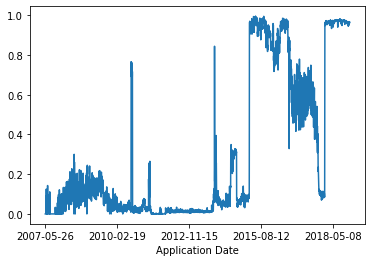

In [30]:
res.plot()

Итак, где-то с 2015-ого года внешние рейтинги перестают использоваться в Lending Club. Созможно, причина в появлении внутренних моделей.

Поскольку оба наших датасета из одобренных заявок фильтруются 2015-м годом, это не так портит картину, однако заставляет задуматься о грядущем структурном сдвиге в модели.

## 4. Визуальный анализ и выбросы

In [41]:
X.drop('Risk_Score_adj', axis = 1, inplace=True)

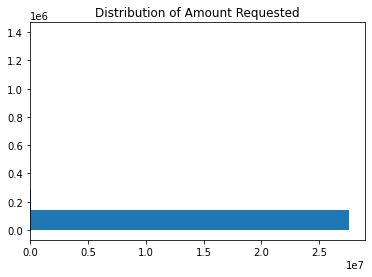

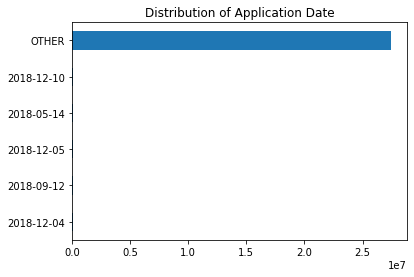

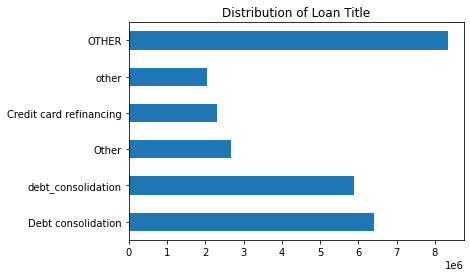

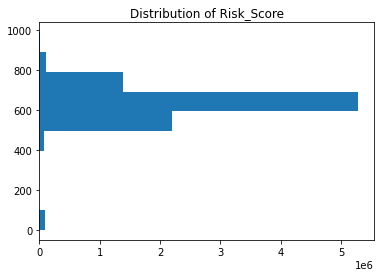

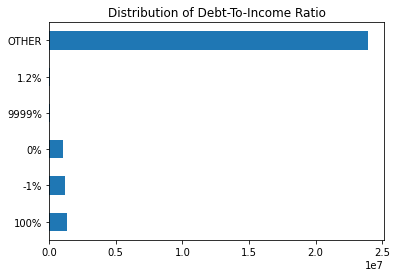

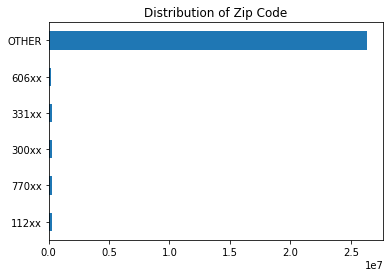

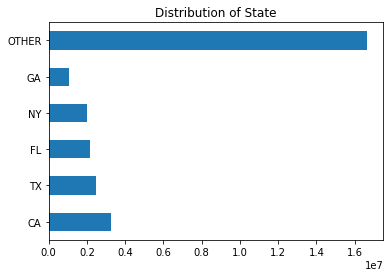

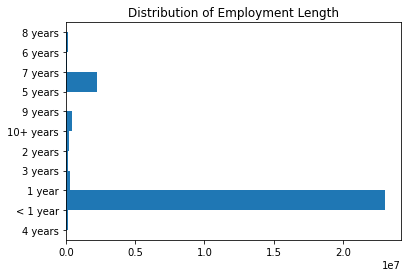

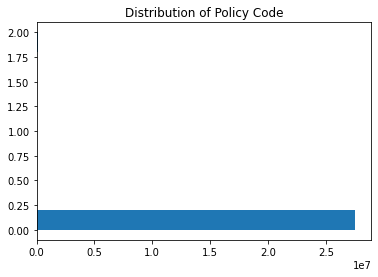

In [42]:
for col in X.columns:
    # есть колонки со всеми пропусками, пропускаем их
    if X[col].isna().sum() != X.shape[0]:
        # если переменная категориальная, а вариантов > 15, строим распределение ТОП-15 значений + Other
        if (isinstance(X[col][0], str)) & (X[col].unique().shape[0] > 15):
            graph_df = X[col].value_counts().head()
            graph_df = graph_df.append(pd.Series({'OTHER': X.shape[0] - graph_df.sum()}))
            graph_df.plot.barh()
            plt.title(f'Distribution of {col}')
            plt.show()
        # общий случай
        else:
            plt.hist(X.loc[~(X[col].isna()), col], orientation='horizontal')
            plt.title(f'Distribution of {col}')
            plt.show()
    else:
        print(f'{col} is skipped!')

***

# Выводы 

На данных можно построить аппликативную модель. Данные разделяются на одобренные и отклоненные заявки. По одобренным займам значительно большее число факторов, но наблюдений меньше. 

__Одобренные заявки__ разделяются на 2 подмодуля: займы на 3 и на 5 лет. Некоторые авторы рекомендуют фильтровать выдачи с 2010-ого года (до этого заполняемость хуже), но мы пока этого не делаем.

__Отклоненные заявки__ могут иметь структурный сдвиг: с 2015 г. значительно увличивается количество пропусков по внешних скорам заемщиков. Тем не менее, с учетом вызревания это слабо повлияет на наши данные. Кроме того, в с 5 ноября 2013 г. произошла смена поставшика скоров: скоры FICO заменены на Vantage.

Преимущества использования датасета:
* Сравнительно большое число наблюдений
* Критических выбросов не обнаружено
* Возможен учёт reject inference
* есть различные поколения выдач, можно смотреть динамику во времени
* потенциально есть датасет 2020q3, но мне не понравилось качество данных. По идее мы можем получить примерно + 1-1.5 года доп. информации

Основные проблемы:
* большое число факторов сомнительные и могут содержать информацию из будущего. Однозначно некорректные факторы уже отфильтровал, оставшиеся разделил на хорошие 'good' и потенциально некорректные 'risky'
* достаточно большое число пропусков, но они, кажется, часто имеют экономическое объяснение (например, при отсутствии импотеки должна отсутствовать дата получения ипотеки)
* идентификаторы клиентов не заполнены

***

# Appendix

In [24]:
# df1 = pd.read_csv('C:/Users/antonmarkov/01-studies/01-phd/year-3/model-risks/credit_scoring_project/datasets/03_lending_club/raw_files/Loan_status_2007-2020Q3.gzip', low_memory=False)
# df2 = pd.read_csv('./raw_files/accepted_2007_to_2018Q4.csv', low_memory=False)

In [25]:
# res1 = pd.DataFrame(df1.groupby('issue_d').id.count()).reset_index()
# res2 = pd.DataFrame(df2.groupby('issue_d').id.count()).reset_index()

# res1.columns = ['issue_d', 'nrow_2019q3']
# res2.columns = ['issue_d', 'nrow_2020q4']

In [26]:
# pd.merge(res1, res2, how='left').sort_values('issue_d').tail(60)

In [27]:
# df_acc = pd.read_csv('C:/Users/antonmarkov/01-studies/01-phd/year-3/model-risks/credit_scoring_project/datasets/03_lending_club/raw_files/Loan_status_2007-2020Q3.gzip', low_memory=False)